# Model Creation

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pytz
import pandas as pd
import matplotlib.pyplot as plt

from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import interp1d
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

## Import Data
Start by importing the training and testing data.

In [2]:
train = pd.read_csv(r'C:\Users\fwhal\Downloads\CME528\Project\Repo-2\BreakinBadCode\Final_DataFrames\FINAL_training_data_Model1_FINAL.csv')
train

,Producer,District,Year,Ratings Average,WineType,January Max Temp (°C),January Min Temp (°C),January Avg Temp (°C),January Max Relative Humidity,January Min Relative Humidity,...,December Avg Relative Humidity,December Cumulative Rain (mm),December Cumulative Snow (mm),December Cumulative Precip (mm),December Avg Cloud Cover (%),December Max Wind Speed (Km/h),December Min Wind Speed (Km/h),December Avg Wind Speed (Km/h),December Avg Daylight Hours,Type
0,Fisher Vineyards,Sonoma,2006,4.4,cabernet sauvignon,19.279500,1.7795,9.132726,100.000000,30.354403,...,93.785441,130.900000,0.00,130.900000,55.864248,28.079998,0.36,6.658719,9.532257,most_user_rated
1,Fisher Vineyards,Sonoma,2009,4.6,cabernet sauvignon,24.079498,-1.5705,9.424527,99.667244,25.833523,...,94.705297,75.700001,0.00,75.700001,65.534946,18.844202,0.36,5.626661,9.531201,best_user_rated
2,Fisher Vineyards,Sonoma,2010,4.5,cabernet sauvignon,16.279500,2.2795,9.142336,100.000000,46.581997,...,97.456224,206.300002,0.00,206.300002,81.970429,26.230639,0.36,7.106632,9.532365,NaN
3,Fisher Vineyards,Sonoma,2011,4.5,cabernet sauvignon,21.279500,-2.0205,8.641059,99.669850,34.317420,...,86.561312,3.000000,0.00,3.000000,34.471774,19.052810,0.36,5.622818,9.533643,top_ranked
4,Fisher Vineyards,Sonoma,2013,4.5,cabernet sauvignon,17.929500,-2.0205,6.742806,99.660610,34.560658,...,86.215179,8.500000,0.07,8.570000,26.384409,18.218275,0.36,5.389955,9.531514,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,Quinta do Vallado,Freixo de Espada a Cinta,2018,4.3,superior (organic vineyards),17.838501,0.3885,8.070691,100.000000,48.021343,...,98.711863,55.500000,0.00,55.500000,72.076613,23.377836,0.00,4.786329,9.266552,NaN
293,Quinta do Vallado,Freixo de Espada a Cinta,2019,4.3,superior (organic vineyards),16.488500,-3.9115,5.454024,100.000000,30.749796,...,95.350414,145.600000,0.00,145.600000,66.778226,34.454840,0.00,7.201181,9.267922,top_ranked
294,Quinta do Vallado,Freixo de Espada a Cinta,2020,4.3,superior (organic vineyards),17.688501,-2.4615,6.816322,100.000000,35.641990,...,96.307585,60.400000,0.00,60.400000,64.638441,18.844202,0.36,7.005120,9.263821,NaN
295,Quinta do Vallado,Freixo de Espada a Cinta,2021,4.2,superior (organic vineyards),20.038500,-3.5615,6.512895,100.000000,38.647420,...,96.930360,53.500000,0.00,53.500000,70.969086,23.333443,0.00,6.326624,9.264957,NaN


## Data Cleaning Engineering
Following the input of the data, extensive measurements must be taken to clean and format the data. 

The cleaning process involves: 
- Drops duplicate rows
- Fill NaN values 



In [3]:
def Cleaning_Data(DataFrame_Clean):
    """
    Input: initial DataFrame data

    Cleans a DataFrame_ through four processes:
        1. Drops duplicate rows
        2. fills NaN values 

    Output: Cleaned DataFrame
    """

    #Drops any rows with the name producer/year
    DataFrame_Clean['Producer_Year'] = DataFrame_Clean['Producer'] + DataFrame_Clean['Year'].astype(str)
    DataFrame_Clean = DataFrame_Clean.drop_duplicates(subset = 'Producer_Year')

    #Fills NaN values with the data infront of it. Since hourly data wont have large variation between hours, this approach is valid
    DataFrame_Clean = DataFrame_Clean.fillna(0)

    return DataFrame_Clean

In [4]:
def Features(DataFrame):
    """
    Adds all features to the dataframe
    """

    #Add feature for seasonal average temperature
    DataFrame['Winter_Avg_Temp'] = DataFrame[['December Avg Temp (°C)', 'January Avg Temp (°C)', 'February Avg Temp (°C)']].mean(axis = 1)
    DataFrame['Spring_Avg_Temp'] = DataFrame[['March Avg Temp (°C)', 'April Avg Temp (°C)', 'May Avg Temp (°C)']].mean(axis = 1)
    DataFrame['Summer_Avg_Temp'] = DataFrame[['June Avg Temp (°C)', 'July Avg Temp (°C)', 'August Avg Temp (°C)']].mean(axis = 1)
    DataFrame['Fall_Avg_Temp'] = DataFrame[['September Avg Temp (°C)', 'October Avg Temp (°C)', 'November Avg Temp (°C)']].mean(axis = 1)

    #Add feature for humidity average temperature
    DataFrame['Winter_Avg_Humid'] = DataFrame[['December Avg Relative Humidity', 'January Avg Relative Humidity', 'February Avg Relative Humidity']].mean(axis = 1)
    DataFrame['Spring_Avg_Humid'] = DataFrame[['March Avg Relative Humidity', 'April Avg Relative Humidity', 'May Avg Relative Humidity']].mean(axis = 1)
    DataFrame['Summer_Avg_Humid'] = DataFrame[['June Avg Relative Humidity', 'July Avg Relative Humidity', 'August Avg Relative Humidity']].mean(axis = 1)
    DataFrame['Fall_Avg_Humid'] = DataFrame[['September Avg Relative Humidity', 'October Avg Relative Humidity', 'November Avg Relative Humidity']].mean(axis = 1)

    #---------------------------will add a precip column----------------------------#
    #Add feature for seasonal average precip
    DataFrame['Winter_Avg_Precip'] = (
        DataFrame[['December Cumulative Rain (mm)', 'December Cumulative Snow (mm)', 
                   'January Cumulative Rain (mm)', 'January Cumulative Snow (mm)', 
                   'February Cumulative Rain (mm)', 'February Cumulative Snow (mm)']]
        .mean(axis=1)
    )
    DataFrame['Spring_Avg_Precip'] = (
        DataFrame[['March Cumulative Rain (mm)', 'March Cumulative Snow (mm)', 
                   'April Cumulative Rain (mm)', 'April Cumulative Snow (mm)', 
                   'May Cumulative Rain (mm)', 'May Cumulative Snow (mm)']]
        .mean(axis=1)
    )
    DataFrame['Summer_Avg_Precip'] = (
        DataFrame[['June Cumulative Rain (mm)', 'June Cumulative Snow (mm)', 
                   'July Cumulative Rain (mm)', 'July Cumulative Snow (mm)', 
                   'August Cumulative Rain (mm)', 'August Cumulative Snow (mm)']]
        .mean(axis=1)
    )
    DataFrame['Fall_Avg_Precip'] = (
        DataFrame[['September Cumulative Rain (mm)', 'September Cumulative Snow (mm)', 
                   'October Cumulative Rain (mm)', 'October Cumulative Snow (mm)', 
                   'November Cumulative Rain (mm)', 'November Cumulative Snow (mm)']]
        .mean(axis=1)
    )

    #Add feature for seasonal average cloud cover
    DataFrame['Winter_Avg_Cloud_Cover'] = DataFrame[['December Avg Cloud Cover (%)', 'January Avg Cloud Cover (%)', 'February Avg Cloud Cover (%)']].mean(axis = 1)
    DataFrame['Spring_Avg_Cloud_Cover'] = DataFrame[['March Avg Cloud Cover (%)', 'April Avg Cloud Cover (%)', 'May Avg Cloud Cover (%)']].mean(axis = 1)
    DataFrame['Summer_Avg_Cloud_Cover'] = DataFrame[['June Avg Cloud Cover (%)', 'July Avg Cloud Cover (%)', 'August Avg Cloud Cover (%)']].mean(axis = 1)
    DataFrame['Fall_Avg_Cloud_Cover'] = DataFrame[['September Avg Cloud Cover (%)', 'October Avg Cloud Cover (%)', 'November Avg Cloud Cover (%)']].mean(axis = 1)
    
    #Add feature for seasonal daylight hours
    DataFrame['Winter_Avg_Daylight_Hrs'] = DataFrame[['December Avg Daylight Hours', 'January Avg Daylight Hours', 'February Avg Daylight Hours']].mean(axis = 1)
    DataFrame['Spring_Avg_Daylight_Hrs'] = DataFrame[['March Avg Daylight Hours', 'April Avg Daylight Hours', 'May Avg Daylight Hours']].mean(axis = 1)
    DataFrame['Summer_Avg_Daylight_Hrs'] = DataFrame[['June Avg Daylight Hours', 'July Avg Daylight Hours', 'August Avg Daylight Hours']].mean(axis = 1)
    DataFrame['Fall_Avg_Daylight_Hrs'] = DataFrame[['September Avg Daylight Hours', 'October Avg Daylight Hours', 'November Avg Daylight Hours']].mean(axis = 1)


    
    return DataFrame

## Selecting Features and Split Data

The feature selection function takes in all the added features, removing many of the ones that were determined to not help the data well. 
- Removed features were done based on the utility graph later on

In [5]:
def Feature_Selection(data):
    """
    Input: Raw data, with every feature from the cleaned train data set
        Commenting them in and out, certain features are chosen for the final model 
    Output: Final dataset, with certain features chosen 
    """
    feature_selected = [
                        # 'Year',

                        'Winter_Avg_Temp', 

                        'Spring_Avg_Temp',

                        'Summer_Avg_Temp',
                        # 'June Avg Temp (°C)',
                        # 'July Avg Temp (°C)',
                        # 'August Avg Temp (°C)',                                       

                        # 'Fall_Avg_Temp',

                        # 'Winter_Avg_Humid', 

                        'Spring_Avg_Humid',

                        # 'Summer_Avg_Humid',

                        # 'Fall_Avg_Humid',

                        'Winter_Avg_Precip', 

                        'Spring_Avg_Precip',

                        # 'Summer_Avg_Precip',

                        # 'Fall_Avg_Precip',

                        # 'Winter_Avg_Cloud_Cover',
                        'January Avg Cloud Cover (%)',
                        'February Avg Cloud Cover (%)',

                        'Spring_Avg_Cloud_Cover',
                        'March Avg Cloud Cover (%)',
                        # 'April Avg Cloud Cover (%)',
                        # 'May Avg Cloud Cover (%)',

                        'Summer_Avg_Cloud_Cover',

                        # 'Fall_Avg_Cloud_Cover',

                        'Winter_Avg_Daylight_Hrs',

                        'Spring_Avg_Daylight_Hrs',

                        'Summer_Avg_Daylight_Hrs',

                        # 'Fall_Avg_Daylight_Hrs',

                        
                        ]

    selected_data = data[feature_selected]
    selected_data = selected_data.astype(np.float32)

    return selected_data

In [6]:
train = Cleaning_Data(train)
train = Features(train)

X_data = Feature_Selection(train)
y_data = train['Ratings Average']

model = RandomForestRegressor() 

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, train_size = 0.8, random_state = 42)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(r2_score(y_val, y_pred))

0.5695885788449064



Top 15 Important Features:
                         Feature  Importance
3               Spring_Avg_Humid    0.169544
11       Winter_Avg_Daylight_Hrs    0.103547
1                Spring_Avg_Temp    0.098783
2                Summer_Avg_Temp    0.095086
13       Summer_Avg_Daylight_Hrs    0.085662
12       Spring_Avg_Daylight_Hrs    0.083764
0                Winter_Avg_Temp    0.079895
10        Summer_Avg_Cloud_Cover    0.077531
4              Winter_Avg_Precip    0.044782
7   February Avg Cloud Cover (%)    0.042424
5              Spring_Avg_Precip    0.035738
9      March Avg Cloud Cover (%)    0.030734
8         Spring_Avg_Cloud_Cover    0.028155
6    January Avg Cloud Cover (%)    0.024355


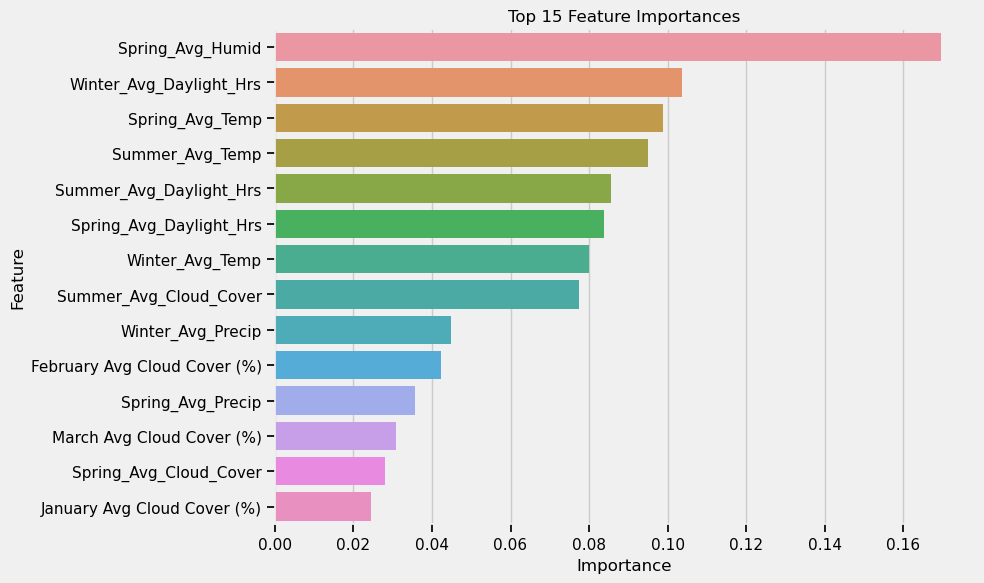

In [7]:
# Feature importances
importances = model.feature_importances_
feature_names = X_data.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 15 Important Features:")
print(feature_importance_df.head(15))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

In [8]:
for i in train.columns:
    print(i)

Producer
District
Year
Ratings Average
WineType
January Max Temp (°C)
January Min Temp (°C)
January Avg Temp (°C)
January Max Relative Humidity
January Min Relative Humidity
January Avg Relative Humidity
January Cumulative Rain (mm)
January Cumulative Snow (mm)
January Cumulative Precip (mm)
January Avg Cloud Cover (%)
January Max Wind Speed (Km/h)
January Min Wind Speed (Km/h)
January Avg Wind Speed (Km/h)
January Avg Daylight Hours
February Max Temp (°C)
February Min Temp (°C)
February Avg Temp (°C)
February Max Relative Humidity
February Min Relative Humidity
February Avg Relative Humidity
February Cumulative Rain (mm)
February Cumulative Snow (mm)
February Cumulative Precip (mm)
February Avg Cloud Cover (%)
February Max Wind Speed (Km/h)
February Min Wind Speed (Km/h)
February Avg Wind Speed (Km/h)
February Avg Daylight Hours
March Max Temp (°C)
March Min Temp (°C)
March Avg Temp (°C)
March Max Relative Humidity
March Min Relative Humidity
March Avg Relative Humidity
March Cumulati